#**EfficientNet**

- In this notebook we are going to explain indepth about pipe line and code for the classification using EfficientNet, The model we are going to use is EfficientNet-b0 but according to the task, you can try out with the different version of EfficientNets (i.e B-1 to B-7), the model code is modular you can just change the value of **phi** for getting the family of EfficientNets, We have used a heavy augmentation,
you will be seeing what sort of Augmentation have we used to get a better accuracy on this dataset you will be seeen in deapth explanation in the subsequent code shells.

In [1]:
import os
import time
from typing import Iterable
from dataclasses import dataclass
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


#**Download Data**

This our custom dataset we have took all the images from different platforms, 

This dataset consist of 5 classes, for train and val respectively

Classes includes = (Electric_guitar, ipod, llama, microscope, owl)

In [2]:
if not os.path.exists("data.zip"):
    !wget -qnc "https://www.dropbox.com/sh/9d0l1qry12hide5/AAAwzmjErCSUg78Yoi8Gpr9ga?dl=0" -O data.zip
!unzip -q data.zip

mapname:  conversion of  failed


#**Configurations**

In [3]:
batch_size: int = 64
epochs_count: int = 550 
init_learning_rate: float = 0.005
test_interval: int = 1  
data_root: str = "/content" 
num_workers: int = 2  
device = torch.device("cuda")
decay_rate: float = 0.2 
log_interval = 5

In [4]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 22 # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [5]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = batch_size
    epochs_count: int = epochs_count             
    init_learning_rate: float = init_learning_rate  #0.005  # initial learning rate for lr scheduler   #TODO  0.01 is too large
    log_interval: int = log_interval  
    test_interval: int = test_interval
    data_root: str = data_root
    num_workers: int = num_workers
    device: str = device  
    decay_rate: float = decay_rate   # for lr_scheduler

#**Data Preparation**

**Prepare Data loading and augmentations**

In [6]:
#for Image Scale 1
def image_preprocess_transforms(): 
    
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
        ])
    
    return preprocess


def image_common_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms
    


def data_augmentation_preprocess():
    
    data_augmented_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20, fill=(0,0,0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees= 35),
        transforms.RandomSolarize(threshold = 120, p=0.2),
    ])
    return data_augmented_transforms




**Calcualte Mean and STD**

In [7]:
def get_mean_std(data_root, num_workers=4):
    
    transform = image_preprocess_transforms()
    
    loader = data_loader(data_root, transform = transform, collate = None)

    mean = 0.
    std = 0.
    
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    
    print('mean: {}, std: {}'.format(mean, std))
    
    return mean, std

**Prepare DataLoader**

You all are already familier about "get_data" function but we have change a function little bit,
now we are passing variable resolution batch of images as a input to network

In [8]:

def get_data(batch_size, data_root, num_workers=4):
    
    train_data_path = os.path.join(data_root, 'Train')
       
    mean, std = get_mean_std(data_root=train_data_path, num_workers=num_workers)

    '''
    With the help of collate function we had manage to send 
    variable resolution batch input, we are keeping the 
    resolution in between 160 to 224,
    The collate function that we used only for train_dataloader
    for test_dataloader we are using simple image process trasfrom 
    with the input resolution of 224.
    '''

    def collate(batch):
        rand_img_size = random.randint(160, 224)

        trans = data_augmentation_preprocess()

        train_transforms = transforms.Compose([
            # Resize to rand_img_size x rand_img_size
            trans,
            transforms.Resize((rand_img_size, rand_img_size)),
            # this re-scales image tensor values between 0-1. image_tensor /= 255
            transforms.ToTensor(),
            # subtract mean (0.1307) and divide by variance (0.3081).
            # This mean and variance is calculated on training data (verify yourself)
            transforms.Normalize(mean, std)
        ])
        imgs, labels = zip(*batch)
        imgs = [train_transforms(img) for img in imgs]
        labels = [torch.tensor(label) for label in labels]
        return torch.stack(imgs), torch.stack(labels)
    
    common_transforms = image_common_transforms(mean, std)
         
    # train dataloader
    train_loader = data_loader(train_data_path,
                               collate = collate,
                               transform = None, 
                               batch_size=batch_size,
                               shuffle=True, 
                               num_workers=num_workers
                               )
    
    # test dataloader
    test_data_path = os.path.join(data_root, 'Val')
    
    test_loader = data_loader(test_data_path,
                              collate = None,
                              transform = common_transforms,  # Correction regarding Mistake 2: Originally train_transforms,       
                              batch_size=2,
                              shuffle=False, 
                              num_workers=num_workers,
                              )
    
    return train_loader, test_loader



def data_loader(data_root, collate, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         collate_fn = collate,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

#**Training Setup**

In [9]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [10]:
device = torch.device('cuda')
criterian = nn.CrossEntropyLoss()

In [11]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)
 
        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = criterian(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

In [12]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0

    true_outputs = []
    predicted_probs = []
    predicted_outputs = []

    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += criterian(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        true_outputs.extend(target.cpu().tolist())
        predicted_probs.append(prob.cpu().tolist()) # append a list


        _, pred = prob.data.max(dim=1)
        # extend the output class list
        predicted_outputs.extend(pred.cpu().tolist()) 

        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy / 100.0

In [13]:
def save_model(model, device, model_dir='models', model_file_name='brain.pt'):
    

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return

In [14]:
def load_model(model, model_dir='models', model_file_name='brain.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model

In [15]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), data_augmentation=False):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
        print('Training using GPU')
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4
        print('Training using CPU')

    # data loader1
    train_loader1, test_loader1 = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )


    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
 
    # Calculate Initial Test Loss
 
    init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader1)
    print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss, 
                                                                                   init_val_accuracy*100))
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):


       
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader1, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader1)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            ), "train_loader1"
        )

        
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader1)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            


            if current_loss < best_loss:
                best_loss = current_loss

                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device)


        # scheduler step/ update learning rate
        if scheduler is not None:
            #print("Learning Rate: {:.5f}".format(scheduler.get_last_lr()[0]))
            if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_loss)
                print("Bad Epochs:{}".format(scheduler.num_bad_epochs))
                print("last LR = {}".format(scheduler._last_lr))
            else:
                scheduler.step()
        else:
            print("Learning Rate: {:.5f}".format(optimizer.param_groups[0]['lr']))
 
        
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [16]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID LOSS ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID ACC ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')
    
    fig.savefig('sample_loss_acc_plot.png')
    plt.show()
    
    return   


#**Model Setup**

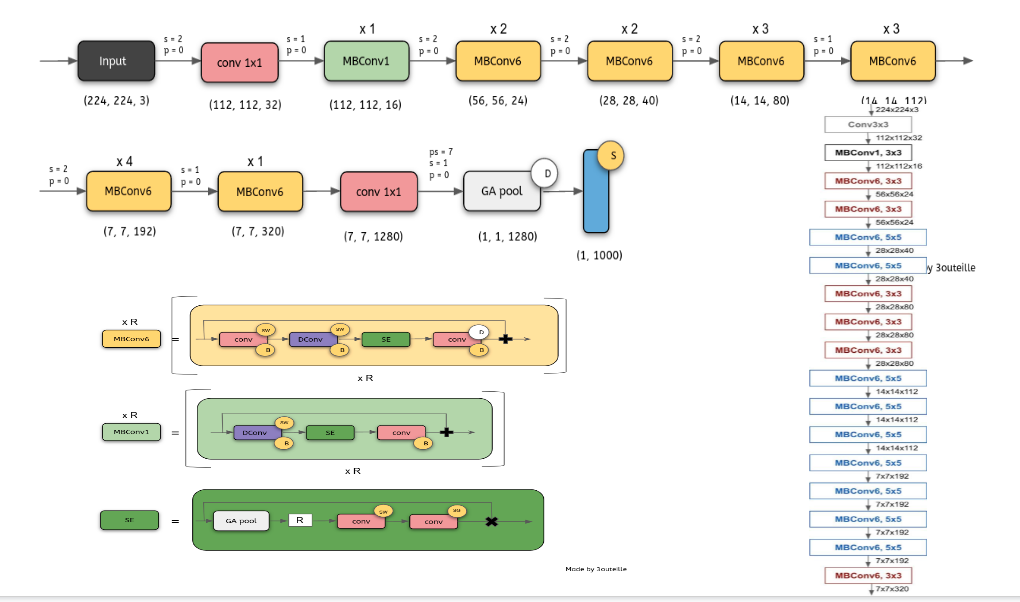

``` python
class CNNBlock(nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, groups=1):
        super(CNNBlock, self).__init__()
        
        padding = self.get_padding(kernel_size, stride)
        
        self.cnn = nn.Sequential(
            nn.ZeroPad2d(padding),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.SiLU()
        )
        

    def get_padding(self, kernel_size, stride):
        p = max(kernel_size - stride, 0)
        return [p // 2, p - p // 2, p // 2, p - p // 2]
    
    def forward(self, x):
        return(self.cnn(x))
    
```
This the Sequential block which consist of Depth wise convolution layer followed by BatchNormalization and Activation, In this block as you can see we have used silu activation just like relu so basically silu is **(x * sigmoid(x))**


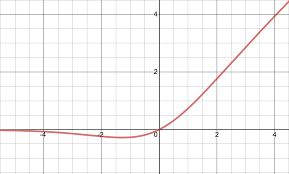


``` python
class Attention(nn.Module):   #it gives channel attention
    def __init__(self, in_channels, reduced_dim):  #input_shape ---> output_shape
        super(Attention, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)
```


This Attention block is also known as squeez exciation block, this is block we have used in inverted resudual block, so basically this block give the weights to the channel or we can say this block is used for giving the attention to the channel


```python
class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, groups = hidden_dim
            ),
            Attention(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)

```

This is the main heart of efficientNet network, firsty this block consiat of two sub blocks, first is simple CNN-Block which we see early and another is Sequential blaock which is the combination of CNN-Block followed by Attention bloack and Batch normalization layer respectively. 

So the question arries when to use Which block, if we have to expand the channel then we are using simple CNN-Block else we will be using Sequential Block.

After every repetated block there is resedual connection, and this is determine from the condtion that where the input_put and hideen channel are same or not. 


In [28]:
from math import ceil
base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]


    
class CNNBlock(nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, groups=1):
        super(CNNBlock, self).__init__()
        
        padding = self.get_padding(kernel_size, stride)
        
        self.cnn = nn.Sequential(
            nn.ZeroPad2d(padding),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.SiLU()
        )
        

    def get_padding(self, kernel_size, stride):
        p = max(kernel_size - stride, 0)
        return [p // 2, p - p // 2, p // 2, p - p // 2]
    
    def forward(self, x):
        return(self.cnn(x))
    
class Attention(nn.Module):   #it gives channel attention
    def __init__(self, in_channels, reduced_dim):  #input_shape ---> output_shape
        super(Attention, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, groups = hidden_dim
            ),
            Attention(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)

class EfficientNet(nn.Module):
    def __init__(self,num_classes):
        super(EfficientNet, self).__init__()
        alpha=1.2 
        beta=1.1
        phi = 0
        width_factor = alpha **phi
        depth_factor = beta**phi 
        dropout_rate = 0.2

        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.network(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Linear(last_channels, num_classes),
        )
        
    '''
    In this function we are making the full sequental block by block by block network,
    this we are doing by using only two for loops one is accesing the data from base model,
    i.e (expand_ratio, channels, repeats, stride, kernel_size), and another is for,
    repeting the inverted resedual block and appending to the one single list wrap it
    over to Sequential API of the Pytorch
    '''


    def network(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

#**Training**

In [29]:
model = EfficientNet(5)


train_config = TrainingConfiguration()

# logging model
optimizer = optim.Adam(
    model.parameters(),
    lr = train_config.init_learning_rate
)

factor = 0.05  
patience = 2  
threshold = 0.0001  
verbose = True     

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience, verbose=verbose, threshold=threshold)
# Try cOSINE SHEDULAR

from torchsummary import summary

summary(model.to("cuda:0"), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
            Conv2d-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
              SiLU-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
            Conv2d-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
              SiLU-8         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-9             [-1, 32, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]             264
             SiLU-11              [-1, 8, 1, 1]               0
           Conv2d-12             [-1, 32, 1, 1]             288
          Sigmoid-13             [-1, 32, 1, 1]               0
        Attention-14         [-1, 32, 1

In [19]:
total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters. \n")


[INFO]: 4,013,953 total parameters. 



In [ ]:
model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, scheduler=None, data_augmentation=True)

Training using GPU
mean: tensor([0.5353, 0.5144, 0.4830]), std: tensor([0.2403, 0.2372, 0.2357])

Test set: Average loss: 1.6095, Accuracy: 119/599 (20%)

Initial Test Loss : 1.609547, 
Initial Test Accuracy : 19.866%

Epoch: 0 
Train Loss: 2.025735 Acc: 0.1943
Elapsed 7.72s, 7.72 s/epoch, 0.77 s/batch, ets 4240.67s train_loader1

Test set: Average loss: 1.8824, Accuracy: 119/599 (20%)

Model Improved. Saving the Model...

Learning Rate: 0.00500
Epoch: 1 
Train Loss: 1.805688 Acc: 0.2348
Elapsed 20.40s, 10.20 s/epoch, 1.02 s/batch, ets 5590.17s train_loader1

Test set: Average loss: 1.6437, Accuracy: 117/599 (20%)

Model Improved. Saving the Model...

Learning Rate: 0.00500
Epoch: 2 
Train Loss: 1.627642 Acc: 0.2148
Elapsed 32.73s, 10.91 s/epoch, 1.09 s/batch, ets 5967.37s train_loader1

Test set: Average loss: 2.0917, Accuracy: 93/599 (16%)

Learning Rate: 0.00500
Epoch: 3 
Train Loss: 1.621046 Acc: 0.2417
Elapsed 46.03s, 11.51 s/epoch, 1.15 s/batch, ets 6283.56s train_loader1

Test s

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4e511add0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4e511add0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 40 
Train Loss: 0.914150 Acc: 0.6308
Elapsed 517.14s, 12.61 s/epoch, 1.26 s/batch, ets 6420.08s train_loader1

Test set: Average loss: 1.0436, Accuracy: 372/599 (62%)

Learning Rate: 0.00500
Epoch: 41 
Train Loss: 0.914574 Acc: 0.6599
Elapsed 529.76s, 12.61 s/epoch, 1.26 s/batch, ets 6407.62s train_loader1

Test set: Average loss: 0.8528, Accuracy: 392/599 (65%)

Model Improved. Saving the Model...

Learning Rate: 0.00500
Epoch: 42 
Train Loss: 0.892229 Acc: 0.6447
Elapsed 542.40s, 12.61 s/epoch, 1.26 s/batch, ets 6395.28s train_loader1

Test set: Average loss: 0.7642, Accuracy: 409/599 (68%)

Model Improved. Saving the Model...

Learning Rate: 0.00500
Epoch: 43 
Train Loss: 0.896901 Acc: 0.6402
Elapsed 554.79s, 12.61 s/epoch, 1.26 s/batch, ets 6380.13s train_loader1

Test set: Average loss: 1.1179, Accuracy: 363/599 (61%)

Learning Rate: 0.00500
Epoch: 44 
Train Loss: 0.939603 Acc: 0.6409
Elapsed 567.63s, 12.61 s/epoch, 1.26 s/batch, ets 6370.03s train_loader1

Test set: Averag

#**Loss And Accuracy Plots**

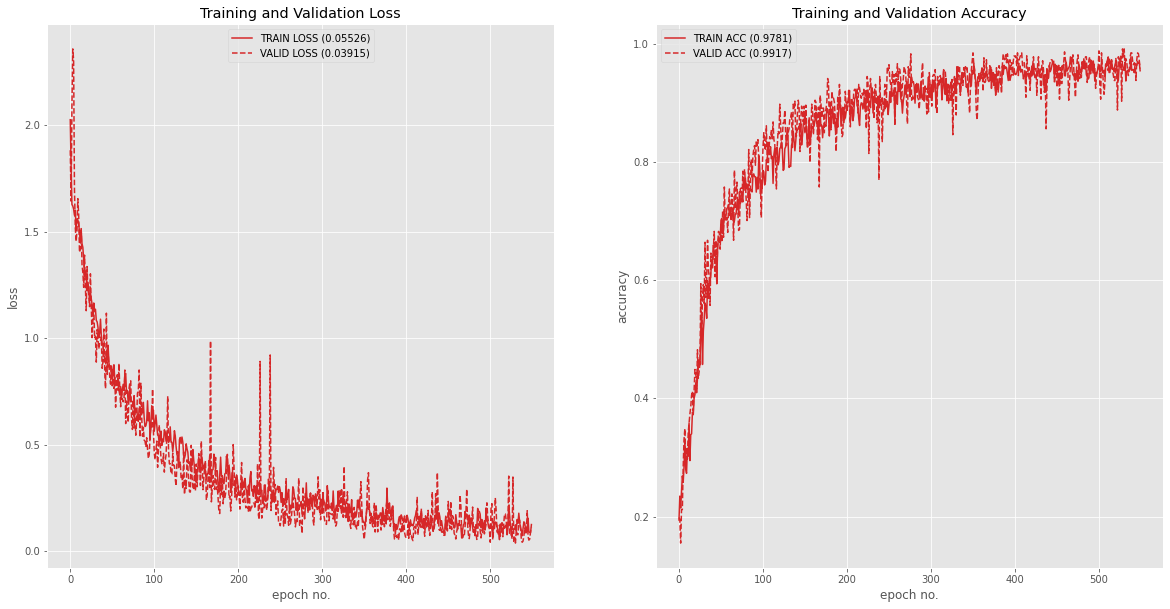

In [ ]:
plot_loss_accuracy(train_loss=[train_loss], 
                   val_loss=[val_loss], 
                   train_acc=[train_acc], 
                   val_acc=[val_acc], 
                   colors=['red'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

#**Inferance**

In [ ]:
def prediction(model, device, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

In [ ]:
def get_sample_prediction(model, data_root, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
        
        
    
    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))
    
    # original image dataset
    test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())
    
    data_len = test_dataset.__len__()
    
    interval = int(data_len/batch_size)
    
    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(index)
        img, _ = test_dataset.__getitem__(index)
        
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        
    inputs = torch.stack(inputs)
        
    cls, prob = prediction(model, device, batch_input=inputs)
    
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()
    
    
    for i, target in enumerate(targets):
        plt.subplot(3, 5, i+1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title('P:{0}({1:.2}), T:{2}'.format(test_dataset.classes[cls[i]], 
                                                     prob[i], 
                                                     test_dataset.classes[targets[i]]))
    fig.savefig('sample_prediction.png')
    plt.show()
    
    return
        
    

mean: tensor([0.5353, 0.5144, 0.4830]), std: tensor([0.2403, 0.2372, 0.2357])


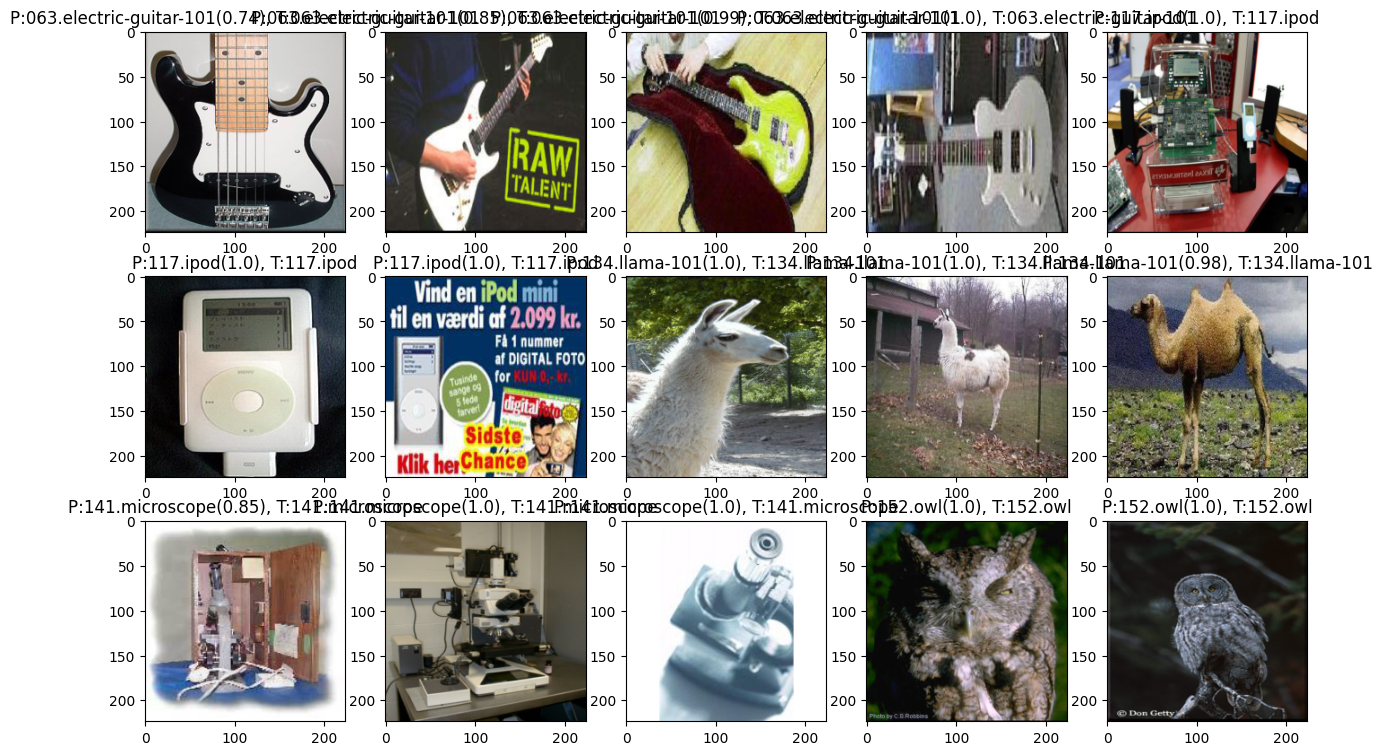

In [ ]:
m = EfficientNet(5)

m = load_model(m)

train_config = TrainingConfiguration()

test_data_path = os.path.join(train_config.data_root, 'Val')

train_data_path = os.path.join(train_config.data_root, 'Train')

mean, std = get_mean_std(train_data_path)


get_sample_prediction(m, test_data_path, mean, std)

#Latency

Here we are checking the latency of the Efficienet-v1, in our next notebook we are going to compare latency of efficienet-v1 and efficienet-v2 under same number of paramerts and same onfigurations

In [30]:
def prediction(model, device, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    # it is important to do model.eval() before prediction
    model.eval()
    data = batch_input.to(device)
    time1 = time.time()
    for i in range(100):
        output = model(data)
    time2 = time.time()
    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy(), time2-time1


def latency(model, data_root, mean, std):
    batch_size = 32

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
             
    
    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))
    
    # original image dataset
    test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())
    
    data_len = test_dataset.__len__()
    
    interval = int(data_len/batch_size)
    
    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(index)
        img, _ = test_dataset.__getitem__(index)
        
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        
    inputs = torch.stack(inputs)
    

    cls, prob, t = prediction(model, device, batch_input=inputs)
    return t

In [31]:
latency(model = model, data_root = '/content/Train', std = 0.5, mean = 0.5)

3.2223708629608154